In [264]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imgforocr/input.png
/kaggle/input/imgforocr2/drawing.png


In [265]:
from IPython.display import clear_output
!pip install keras-ocr
clear_output()

In [266]:
import keras_ocr
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [267]:
images = [ keras_ocr.tools.read('/kaggle/input/imgforocr2/drawing.png')]

(-0.5, 841.5, 594.5, -0.5)

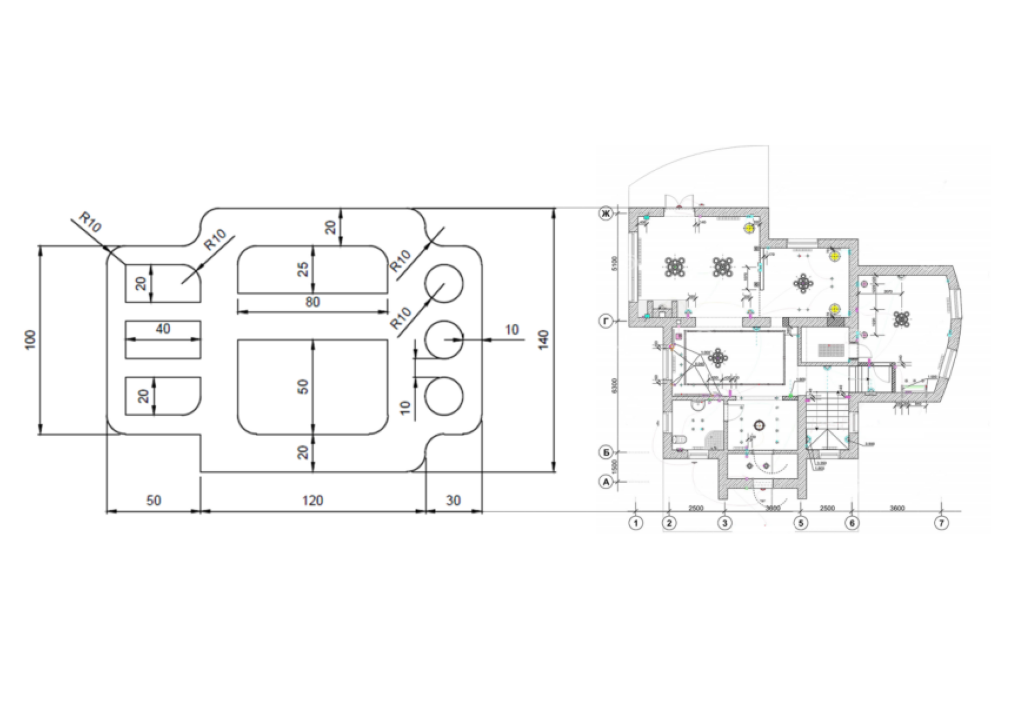

In [268]:
fig = plt.figure(figsize=(32,20))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(images[0])
plt.axis('off')

In [269]:
pipline = keras_ocr.pipeline.Pipeline() #Creting a pipline 

kerasocr_preds = pipline.recognize(images)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 5s 5s/step


(595, 842, 3)


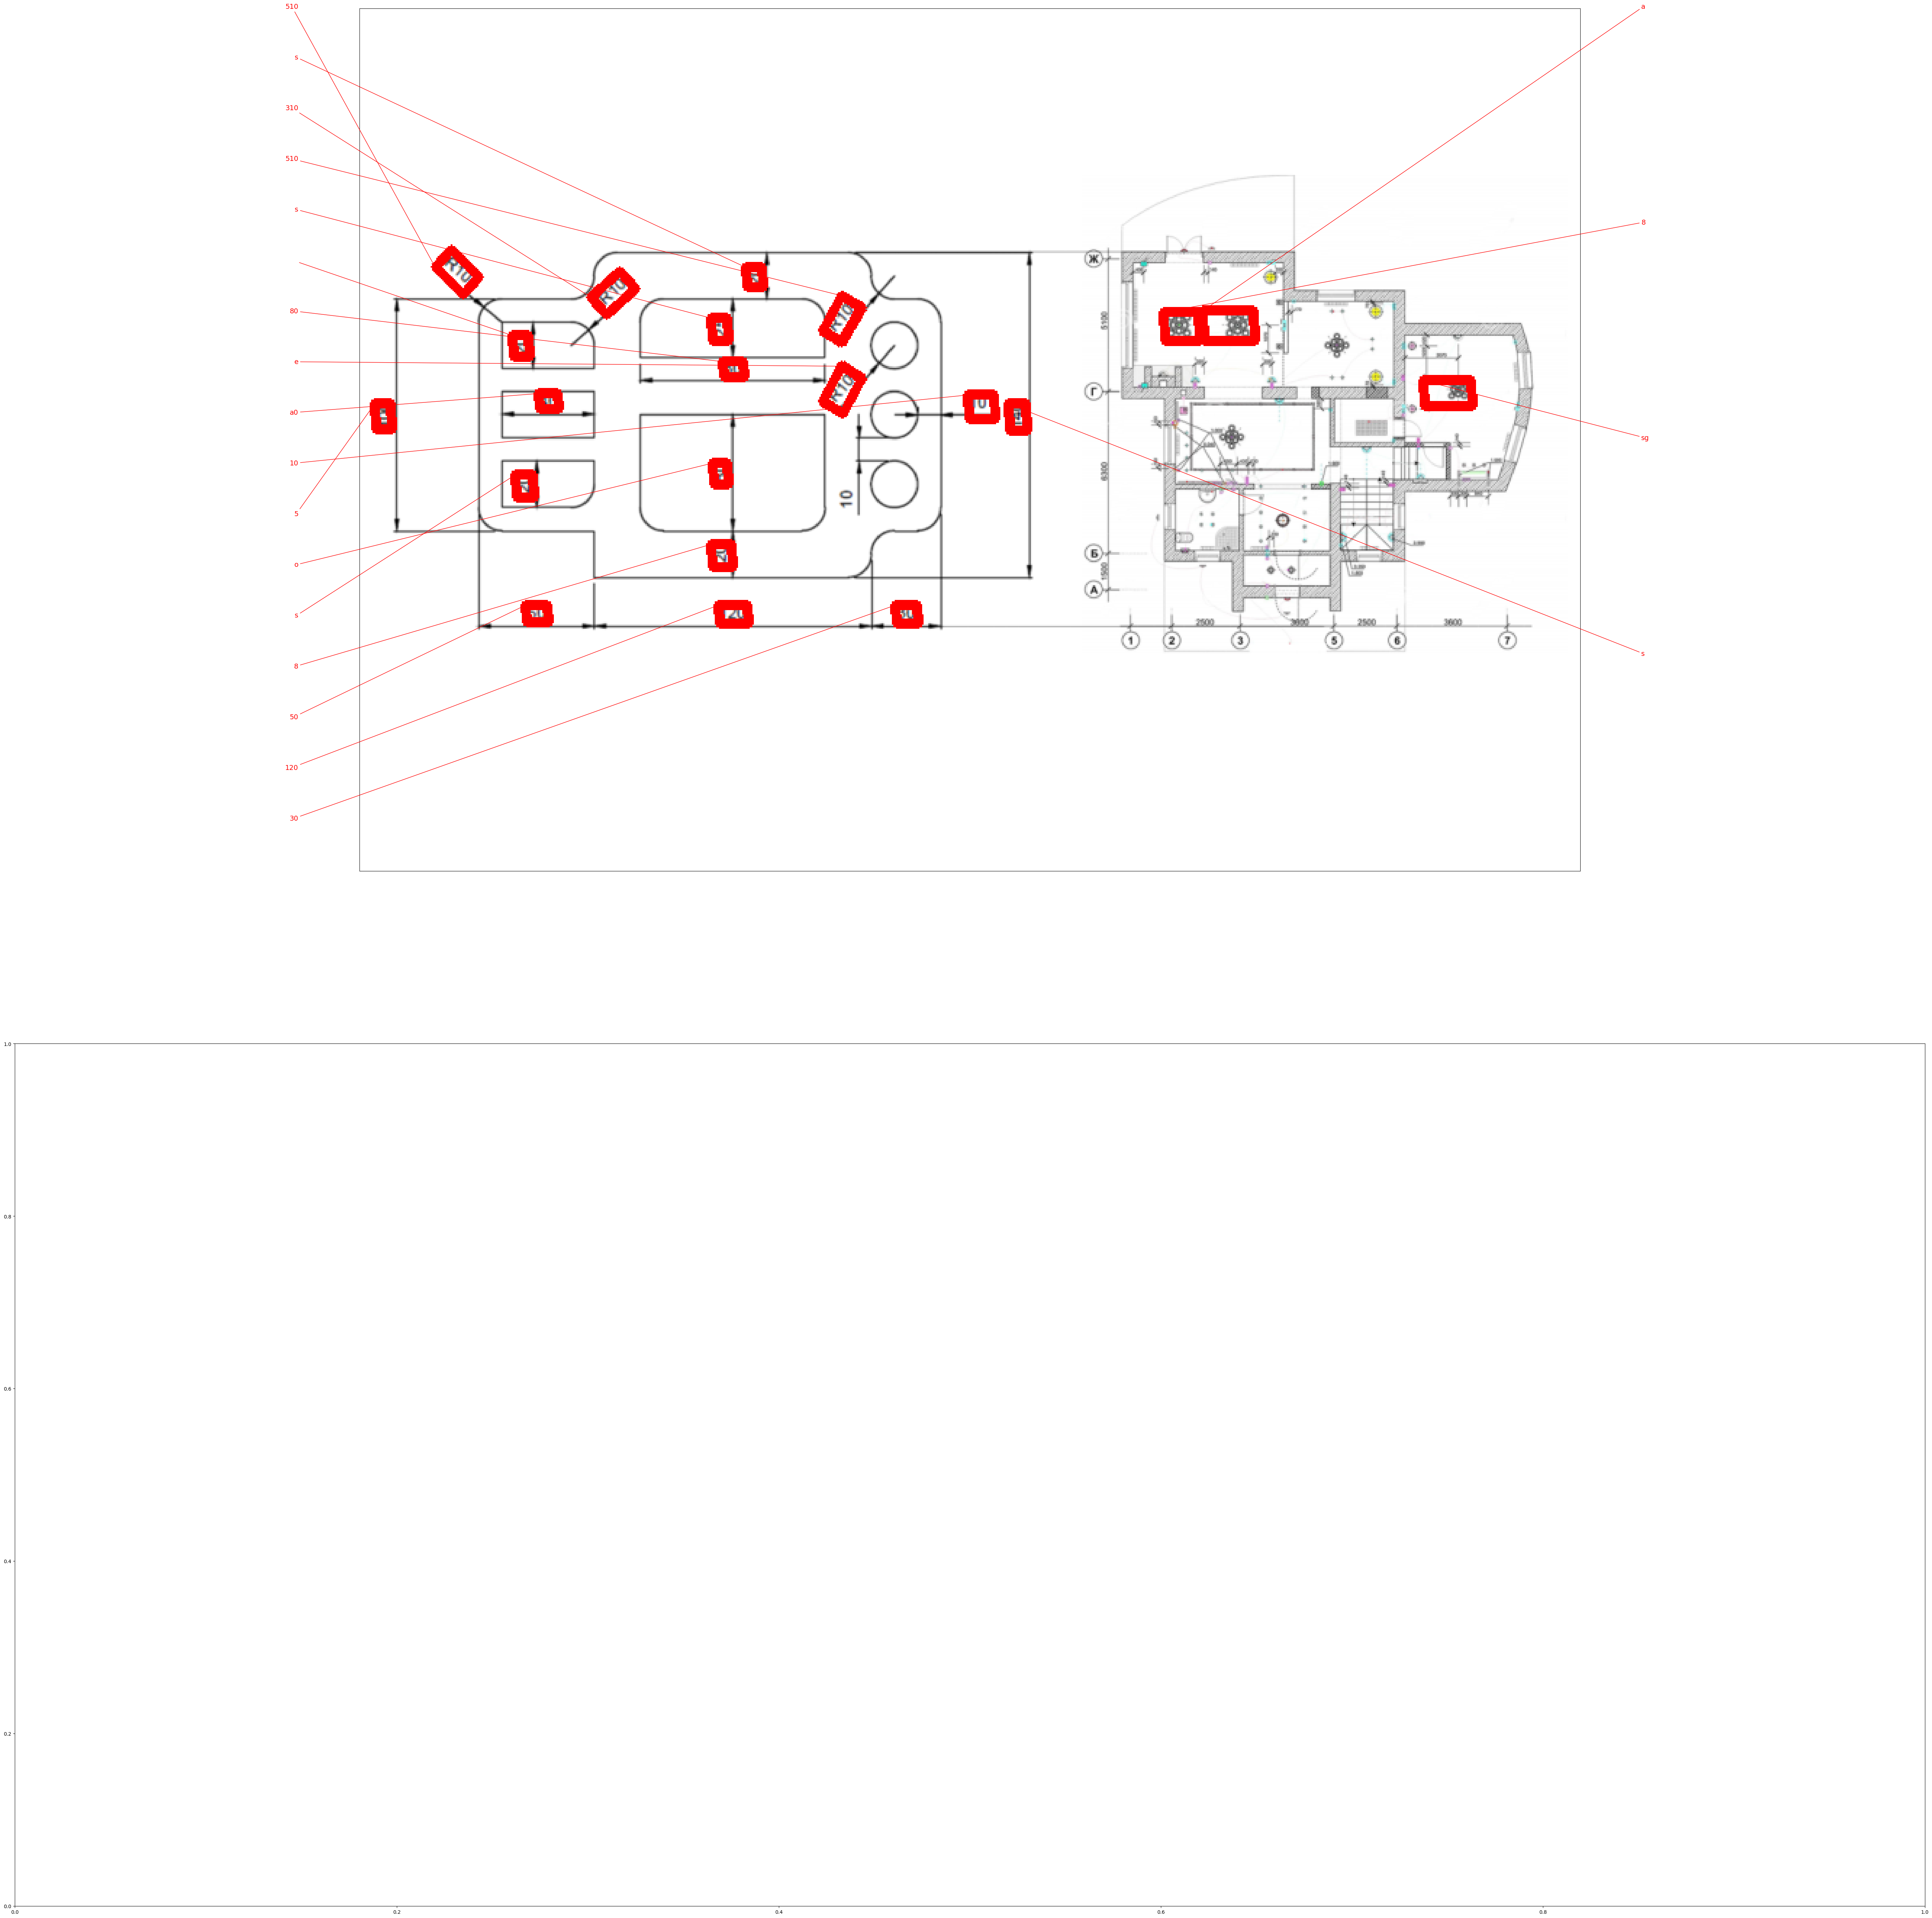

In [270]:
fig,axs = plt.subplots(nrows = 2 , figsize = (70,70))
boxes = []
m = images[0].shape
h = m[0]/2000
w = m[1]/2000
print(images[0].shape)
for ax , image,  prediction in zip(axs , images , kerasocr_preds):
    image2 = image.copy()
    boxes = prediction
#print(boxes[0])
for i in range(len(boxes)):
    #print(boxes[0][i][1])
    top = list(boxes[i][1])
    
    top[0] = top[0] - w
    top[1] = top[1] - w
    top[2] = top[2] + w
    top[3] = top[3] + w
    boxes[i][1][0] =  top[0]
    boxes[i][1][1] =  top[1]
    boxes[i][1][2] =  top[2]
    boxes[i][1][3] =  top[3]
#     print(boxes[i][1])
    
#keras_ocr.tools.drawBoxes(images[0], boxes, color=(255, 0, 0), thickness=2)

          
keras_ocr.tools.adjust_boxes(boxes, scale=1, boxes_format='boxes')
for ax , image,  prediction in zip(axs , images , kerasocr_preds):
    keras_ocr.tools.drawAnnotations(image2, prediction, ax)

1/1 [==============================] - 0s 152ms/step
[('30', array([[ 1.,  1.],
       [15.,  1.],
       [15., 11.],
       [ 1., 11.]], dtype=float32))]


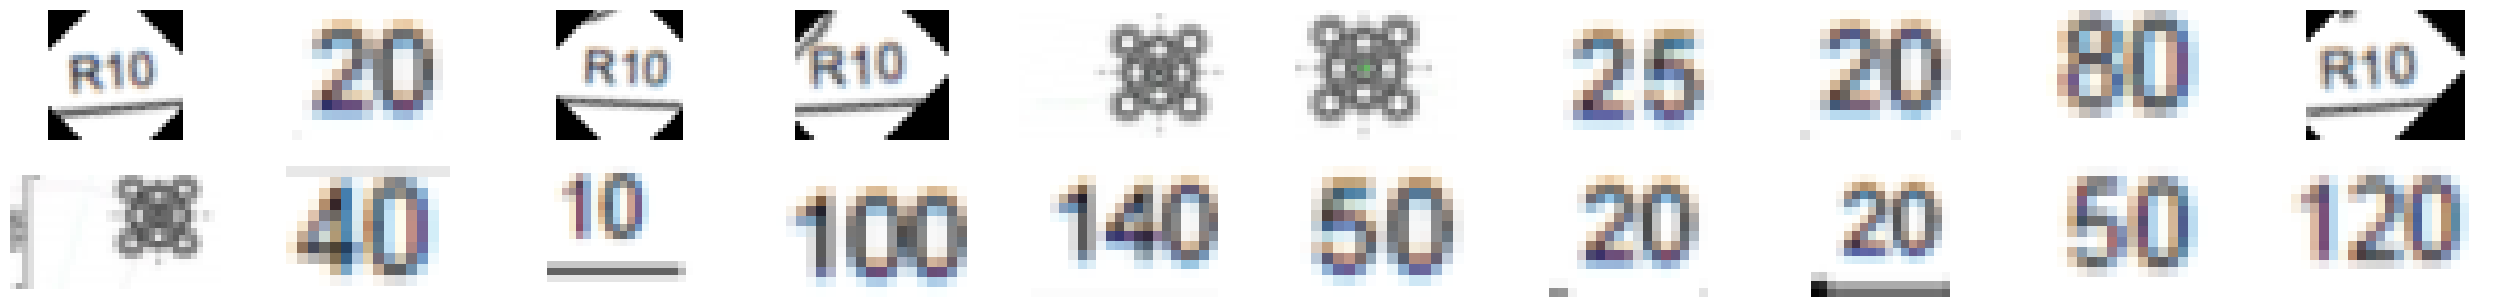

In [271]:
from PIL import Image
cropped = []
image3 = image.copy()
for i in range(len(boxes)):
    slices = list(boxes[i][1])
    # print(slices[0][0],slices[2][0],slices[0][1],slices[2][1])
    top_left_x = int(min([slices[0][0],slices[2][0],slices[1][0],slices[3][0]]))
    top_left_y = int(min([slices[0][1],slices[2][1],slices[1][1],slices[3][1]]))
    bot_right_x = int(max([slices[0][0],slices[2][0],slices[1][0],slices[3][0]]))
    bot_right_y = int(max([slices[0][1],slices[2][1],slices[1][1],slices[3][1]]))
    img4 = image3[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    #img4 = image3.crop((left, top, right, bottom))
    cropped.append(img4)

    
rot_90 = [1,6,7,13,14,15,16,17]
rot_45_anti = [0]
rot_45 = [2,3,9]
ok = [4,5,8,12,20]
texts = []
exclude = [4,5,10,11]
for i in range(len(cropped)):
#     if i in ok:
#         preds2 = pipline.recognize([cropped[i]])
#         texts.append(preds2[0][0])
    cols = cropped[i].shape[0]
    rows = cropped[i].shape[1]
    if i in rot_90:
        cropped[i] = cv2.rotate(cropped[i], cv2.ROTATE_90_CLOCKWISE) 
    elif i in rot_45_anti:
        M = cv2.getRotationMatrix2D((cols/2,rows/2),45,1) 
        cropped[i] = cv2.warpAffine(cropped[i],M,(cols,rows)) 
    elif i in rot_45:
        M = cv2.getRotationMatrix2D((cols/2,rows/2),-45,1) 
        cropped[i] = cv2.warpAffine(cropped[i],M,(cols,rows)) 
#plt.imshow(cropped[len(cropped)-1])


fig = plt.figure(figsize=(32,20))
rows = int(len(cropped)/2)
columns = int(len(cropped)/2)
for i in range(len(cropped)-1):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(cropped[i])
    plt.axis('off')

for i in range(len(cropped)):
    if i not in exclude:
        preds2 = pipline.recognize([cropped[i]])
        texts.append(preds2[0])

In [272]:
boxes
import csv
j= 0
with open('/kaggle/working/data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Symbol", "Text", "Height","Width","X1","Y1","X2","Y2","Radius"])
    for i in range(len(boxes)):
        if i not in exclude:
          start_x, start_y, end_x, end_y = int(boxes[i][1][0][0]), int(boxes[i][1][0][1]), int(boxes[i][1][2][0]), int(boxes[i][1][2][1])
          writer.writerow(["Dimension Text", texts[j][0][0], " "," ",start_x,start_y,end_x,end_y,""])
          j = j+1
    file.close()

